In [2]:
import copy
import math

from PuzzlePiece import *
from SWPuzzleAligner import *
from EuclideanSimilarity import *

In [3]:
# gather all the pieces
target_pieces = {}

for p in ['C','N','NE','E','SE','S','SW','W','NW']:
    target_pieces[p] = PuzzlePiece('3x3_pieces/' + p + '_border.csv', 
                                   border_sampling_rate = .1)

In [4]:
# get the first piece
query = target_pieces.pop('C') # this piece serves as the core

In [5]:
###############################
# REPEAT HERE
##############################
print(target_pieces.keys())

dict_keys(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])


In [6]:
# find the closest match in the other pieces
mx_score = 0
mx_piece = ''

all_align = {}
alignments = {}

for i,p in enumerate(target_pieces):
    
    target = target_pieces[p]
    
    Aligner = SWPuzzleAligner(EuclideanSimilarity())
    alignments = Aligner.Align(Q = query, T = target,
                               window = 5, cutoff_percentile = 0.05,
                               return_top = 5, seq_extension = 0.25) 
    
    if max(alignments['mx']) > mx_score:
        mx_score = max(alignments['mx'])
        mx_piece = p
    
    all_align[p] = alignments
    print(p, alignments)
 
i = all_align[mx_piece]['mx'].index(mx_score)
print('Best: ', mx_piece, mx_score, all_align[mx_piece]['mx_Q'][i], all_align[mx_piece]['mx_T'][i], 
      all_align[mx_piece]['length'][i])
#target = target_pieces.pop(mx_piece)
target = target_pieces[mx_piece]

N {'mx': [24, 24, 17, 16, 16], 'mx_Q': [91, 92, 102, 22, 48], 'mx_T': [83, 83, 60, 43, 116], 'length': [25, 25, 18, 17, 17], 'mx_per_length': [0.96, 0.96, 0.9444444444444444, 0.9411764705882353, 0.9411764705882353]}
NE {'mx': [24, 23, 23, 22, 16], 'mx_Q': [92, 63, 63, 91, 91], 'mx_T': [67, 94, 95, 65, 67], 'length': [25, 24, 24, 23, 24], 'mx_per_length': [0.96, 0.9583333333333334, 0.9583333333333334, 0.9565217391304348, 0.6666666666666666]}
E {'mx': [25, 24, 23, 23, 19], 'mx_Q': [92, 92, 63, 63, 62], 'mx_T': [96, 95, 122, 123, 123], 'length': [26, 25, 24, 24, 22], 'mx_per_length': [0.9615384615384616, 0.96, 0.9583333333333334, 0.9583333333333334, 0.8636363636363636]}
SE {'mx': [17, 16, 14, 14, 14], 'mx_Q': [49, 52, 21, 22, 48], 'mx_T': [108, 21, 41, 41, 108], 'length': [18, 17, 15, 15, 17], 'mx_per_length': [0.9444444444444444, 0.9411764705882353, 0.9333333333333333, 0.9333333333333333, 0.8235294117647058]}
S {'mx': [21, 21, 20, 20, 18], 'mx_Q': [117, 117, 36, 75, 73], 'mx_T': [62, 63,

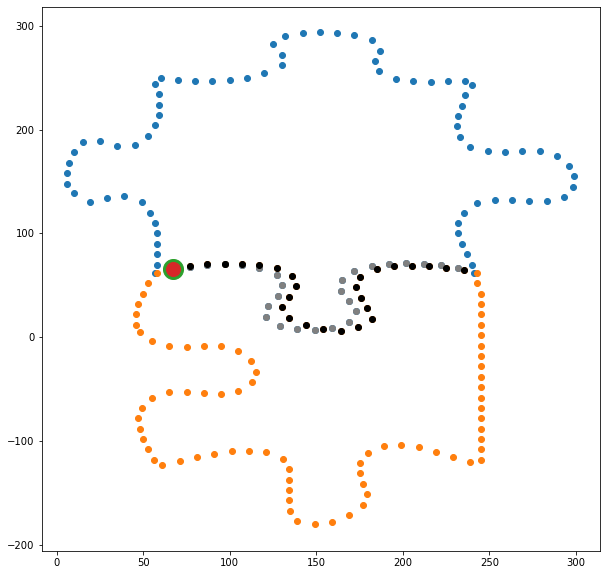

25 92 96 26


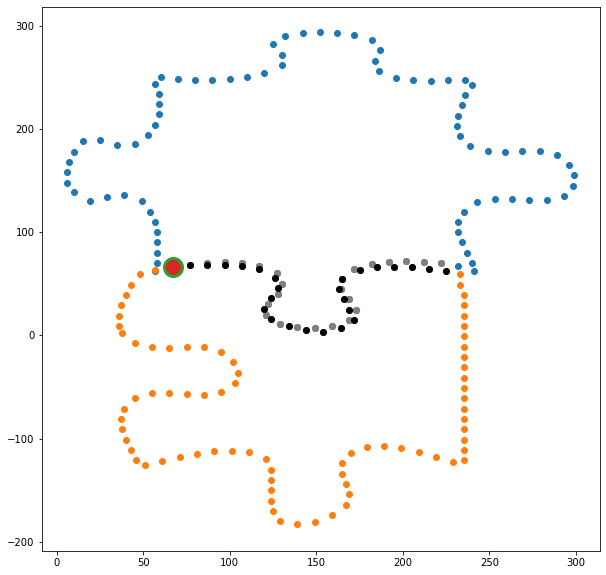

24 92 95 25


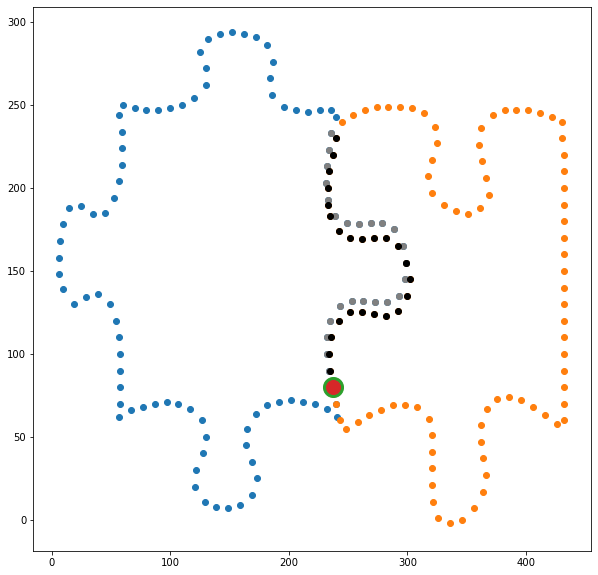

23 63 122 24


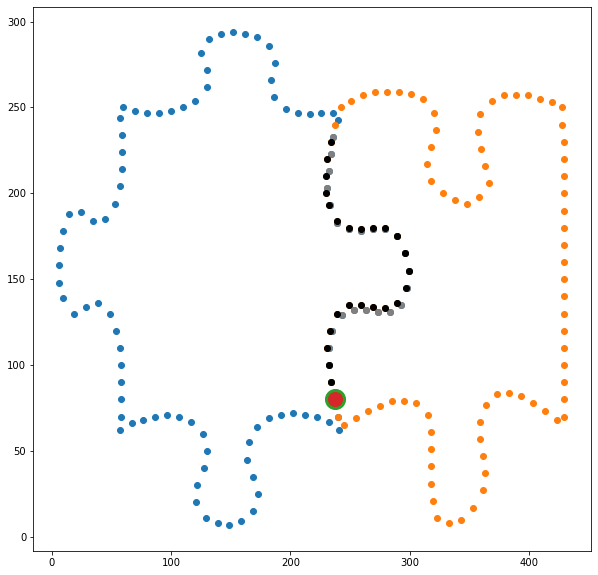

23 63 123 24


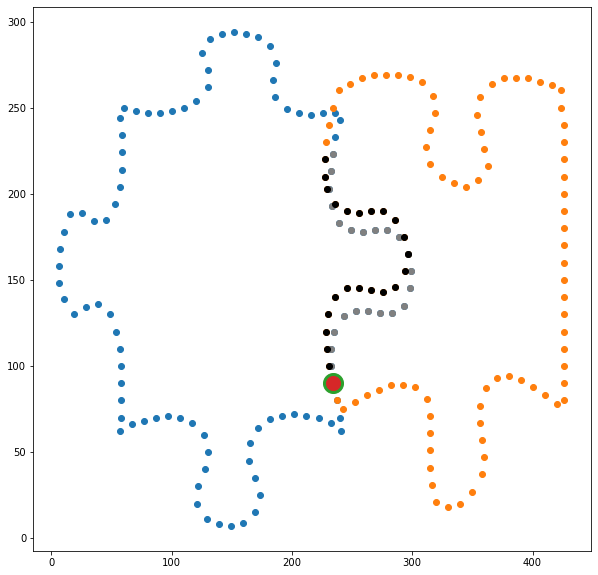

19 62 123 22


In [7]:
######################
# NEED TO ADJUST FOR TOP 5 RETURN FROM ALIGN()
#####################
for i in range(len(all_align[mx_piece]['mx'])):
    mx = all_align[mx_piece]['mx'][i]
    mx_Q = all_align[mx_piece]['mx_Q'][i]
    mx_T = all_align[mx_piece]['mx_T'][i]
    length = all_align[mx_piece]['length'][i]

    # find the aligned points window
    Q_pt = query.border_sample[query.ext_to_old_index[mx_Q]] 
    T_pt = target.border_sample[target.ext_to_old_index[mx_T]] 
    
    # find x,y shift to align pieces based on that one point
    T_xshift = T_pt['x'] - Q_pt['x']
    T_yshift = T_pt['y'] - Q_pt['y'] 

    plt.figure(figsize = [10,10])
    plt.scatter( [query.border_sample[k]['x'] for k,v in query.border_sample.items() ],
                 [query.border_sample[k]['y'] for k,v in query.border_sample.items() ])
    plt.scatter( [target.border_sample[k]['x'] - T_xshift for k,v in target.border_sample.items() ],
                 [target.border_sample[k]['y'] - T_yshift for k,v in target.border_sample.items() ])

    # show best matched points - second will overplot first due to alignment
    plt.scatter( Q_pt['x'], Q_pt['y'], s=400)
    plt.scatter( T_pt['x'] - T_xshift, T_pt['y'] - T_yshift, s=196 ) 

    # show similarity window
    # the black and grey points represent the points in the positive scoring diagonal
    # of the suffix table starting at the maximum scoring point
    # these points are the best locally aligned points
    Q_window = [query.border_sample[query.ext_to_old_index[q]] for q in range(mx_Q - length, mx_Q)]
    plt.scatter( [p['x'] for p in Q_window],
                 [p['y'] for p in Q_window], c = 'grey' )

    T_window = [target.border_sample[target.ext_to_old_index[t]] for t in range(mx_T - length, mx_T)]
    plt.scatter( [p['x'] - T_xshift for p in T_window],
                 [p['y'] - T_yshift for p in T_window], c = 'black' )
    plt.show()
    print(mx, mx_Q, mx_T, length)


In [ ]:
#########################
# REPEAT ABOVE
######################### 

# burn this one for now
target = target_pieces.pop(mx_piece)

In [ ]:
print(len(target.border_sample))

In [ ]:
# combine the pieces into one piece
Q_window_pts = [q for q in range(mx_Q-length, mx_Q)]
T_window_pts = [t for t in range(mx_T-length, mx_T)]

Q_x = [ q[1]['x'] for q in query.border.items() ]
Q_y = [ q[1]['y'] for q in query.border.items() ]

T_orig_x = [ t[1]['x'] for t in target.border.items() ]
T_orig_y = [ t[1]['y'] for t in target.border.items() ]

target.reposition(T_window_pts, query, Q_window_pts)

T_shifted_x = [t[1]['x'] for t in target.border.items() ]
T_shifted_y = [t[1]['y'] for t in target.border.items() ]

plt.figure(figsize = [15,15])
plt.scatter( Q_x, Q_y, c = 'blue', s=16)
plt.scatter( T_orig_x, T_orig_y, c = 'orange', s=16)
plt.scatter( T_shifted_x, T_shifted_y, c = 'black', s=16)
#plt.savefig('placement_figs/temp_translation.png')
            
query.merge(target)

Q_merged_x = [ q[1]['x'] for q in query.border.items() ]
Q_merged_y = [ q[1]['y'] for q in query.border.items() ]

plt.figure(figsize = [15,15])
plt.scatter( Q_merged_x, Q_merged_y, c = 'blue', s=16)
#plt.savefig('placement_figs/temp_composite.png')